# <b>Projekt 2. - Wykrywanie naczyń dna siatkówki oka</b>
### <b>Autorzy:</b> Wiktoria Białasik 151436, Mateusz Czechowski 155921

## <u>Zastosowany język programowania oraz użyte biblioteki</u>
<p> W projekcie wykorzystano język programowania <b>Python</b> oraz posłużono się bibliotekami wymienionymi poniżej. 

In [1]:
import os
import ipywidgets as widgets
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import frangi
from IPython.display import display, clear_output
from skimage.exposure import rescale_intensity, adjust_gamma
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats import gmean
import seaborn as sns
from skimage.filters import threshold_otsu
import skimage.filters as fil
from skimage.measure import moments_central, moments_hu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from skimage.io import imread
from math import sqrt
from skimage.color import rgb2gray


### Odczyt oraz wyświetlenie obrazu wejściwego - zdjęcia siatkówki oka

Dropdown(description='Pick image', options=('01_h.jpg', '01_h.tif', '02_h.jpg', '02_h.tif', '03_h.jpg', '03_h.…

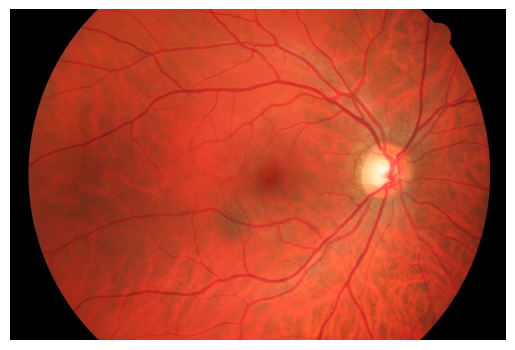

In [ ]:
image = None
filename = ''
dir = './input-data/'
examples_list = [file for file in os.listdir(dir)]

filename_picker = widgets.Dropdown(
    options=examples_list,
    description="Pick image",
    disabled=False
)

def show(change):
    global image, filename, image_color, ground_truth
    clear_output(wait=True)
    display(filename_picker)
    selected_file = change['new']
    
    if selected_file:
        file_path = os.path.join(dir, selected_file)
        image = mpimg.imread(file_path)
        ground_truth = mpimg.imread(file_path.replace('.jpg', '.tif'))

        if len(image.shape) == 3:
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            image_color = (image * 255).astype(np.uint8)
            image = np.mean(image, axis=2)

        filename = os.path.splitext(filename_picker.value)[0]
        print(filename)

filename_picker.observe(show, names='value')
display(filename_picker)


### Wstępne przetwarzanie obrazu

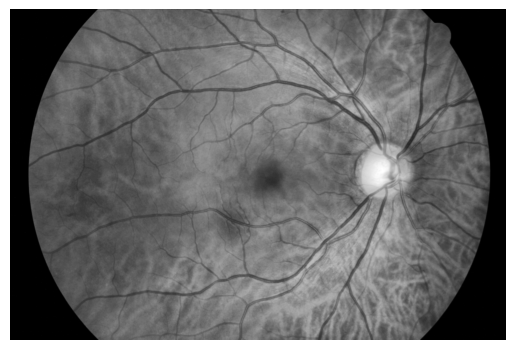

In [3]:
def preprocess_image(image):
    if len(image.shape) == 3:
        green_channel = image[:, :, 1]
    else:
        green_channel = image

    green_channel = green_channel.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_eq = clahe.apply(green_channel)
    median = cv2.medianBlur(image_eq, 5)
    blurred = cv2.GaussianBlur(median, (5, 5), 0)
    final = rescale_intensity(blurred, in_range='image', out_range=(0, 255))
    return blurred

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

blured_image = preprocess_image(image)
show_image(blured_image)


### Właściwe przetwarzanie obrazu - Filtr Frangiego

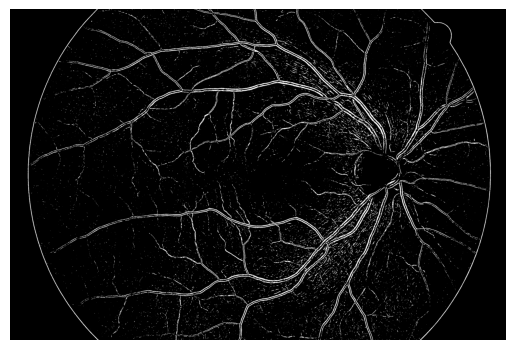

In [4]:
def frangi_filter(image, precentile=95):
    image = image.astype(np.float64) / 255.0
    frangi_result = frangi(image, sigmas=(1, 6), scale_step=2)

    threshold = np.percentile(frangi_result, precentile) 
    binary_mask = (frangi_result > threshold).astype(np.uint8)

    return binary_mask

vessel_mask = frangi_filter(blured_image)
show_image(vessel_mask)


### Końcowe przetwarzanie - oczyszczanie maski

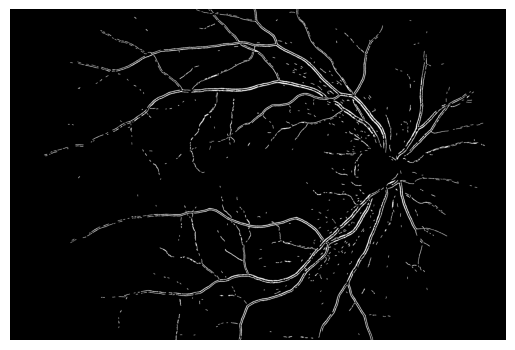

In [5]:
def postprocess_mask(mask):
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    return cleaned

def remove_small_objects(mask, min_size=100):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned_mask = np.zeros_like(mask)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            cleaned_mask[labels == i] = 1
    return cleaned_mask

def remove_n_largest_components(mask, n=2):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels <= 1:
        return mask

    component_areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)]
    component_areas.sort(key=lambda x: x[1], reverse=True)

    for i in range(min(n, len(component_areas))):
        label_to_remove = component_areas[i][0]
        mask[labels == label_to_remove] = 0

    return mask

postprocessed_mask = postprocess_mask(vessel_mask)
postprocessed_mask = remove_small_objects(postprocessed_mask, min_size=35)
postprocessed_mask = remove_n_largest_components(postprocessed_mask)
show_image(postprocessed_mask)


### Nakładanie konturów na oryginalny obraz

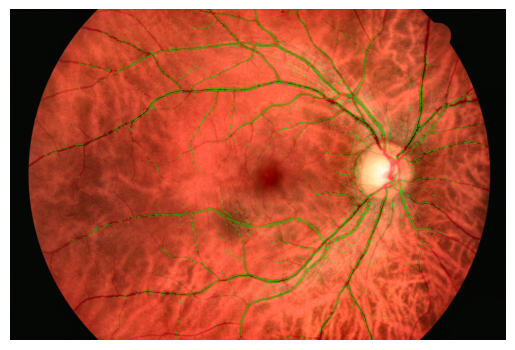

True

In [6]:
def visualize_mask(original, mask, color=(0, 255, 0), alpha=0.7, enhance_contrast=True):
    if enhance_contrast:
        lab = cv2.cvtColor(original, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        original = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    overlay = original.copy()
    overlay[mask == 1] = color
    return cv2.addWeighted(original, 1 - alpha, overlay, alpha, 0)

file_path = os.path.join(dir, filename + '.jpg')

img = cv2.imread(file_path)
vis = visualize_mask(img, postprocessed_mask, color=(0, 255, 0), alpha=0.7)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

output_folder = 'output-data'
os.makedirs(output_folder, exist_ok=True)

output_path = os.path.join(output_folder, 'vessels_overlay.png')
cv2.imwrite(output_path, vis)

Metryki...........

In [8]:
# Obliczanie metryk
ground_truth = (ground_truth > 0).astype(np.uint8)
postprocessed_mask = (postprocessed_mask > 0).astype(np.uint8)

if ground_truth.shape != postprocessed_mask.shape:
    raise ValueError(f"Maski mają różne rozmiary: {ground_truth.shape} vs {postprocessed_mask.shape}")

y_true = ground_truth.flatten()
y_pred = postprocessed_mask.flatten()

cm = confusion_matrix(y_true, y_pred)

print("Macierz pomyłek:")
print(cm)
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(y_true, y_pred)
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

arithmetic_mean = (sensitivity + specificity) / 2
geometric_mean = sqrt(sensitivity * specificity)

print("Macierz pomyłek (confusion matrix):")
print(cm)
print(f"Trafność (accuracy): {accuracy:.4f}")
print(f"Czułość (sensitivity): {sensitivity:.4f}")
print(f"Swoistość (specificity): {specificity:.4f}")
print(f"Średnia arytmetyczna (sensitivity & specificity): {arithmetic_mean:.4f}")
print(f"Średnia geometryczna (sensitivity & specificity): {geometric_mean:.4f}")

Macierz pomyłek:
[[7332655   18801]
 [ 614853  219035]]
Macierz pomyłek (confusion matrix):
[[7332655   18801]
 [ 614853  219035]]
Trafność (accuracy): 0.9226
Czułość (sensitivity): 0.2627
Swoistość (specificity): 0.9974
Średnia arytmetyczna (sensitivity & specificity): 0.6301
Średnia geometryczna (sensitivity & specificity): 0.5119


### Wersja 4.0

In [9]:
def divide_image(image):
    feat_list = list()
    for i in range(len(image)):
        l = 2
        r = 2
        if (i <= 2):
            l = i
        if (i >= len(image)-2):
            r = len(image) - i 
        for j in range(len(image[0])):
            u = 2 
            d = 2
            if (j <= 2):
                u = j
            if (j >= len(image[0])-2):
                d = len(image[0]) - j

            frag = image[i-l:i+r, j-u:j+d, :]
            color_var_r = np.var(frag[:,:,2])
            color_var_g = np.var(frag[:,:,1])
            color_var_b = np.var(frag[:,:,0])
            frag[:,:,0] = 0
            frag[:,:,2] = 0
            frag = rgb2gray(frag)
            hu_moments = cv2.HuMoments(cv2.moments(frag)).flatten()
            hu_moments = np.append(hu_moments, color_var_r)
            hu_moments = np.append(hu_moments, color_var_g)
            hu_moments = np.append(hu_moments, color_var_b)
            feat_list.append(hu_moments)
            del frag
    return feat_list

In [10]:

X_all = []
y_all = []

for idx in [1, 2]: 
    base_name = f"{idx:02d}_h"
    img_path = f"input-data/{base_name}.jpg"
    mask_path = f"input-data/{base_name}.tif"

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    if image is None or mask is None:
        print(f"Skipping {base_name}: missing file.")
        continue

    feats = divide_image(image)
    y = mask
    y[y > 0] = 1
    y = y > 0
    y = y.flatten()

    X_all.extend(feats)
    y_all.extend(y)

X_all = np.array(X_all)
y_all = np.array(y_all)

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_all, y_all)


KNeighborsClassifier(n_neighbors=3)

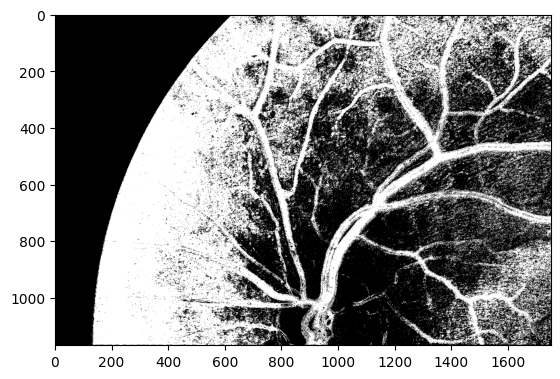

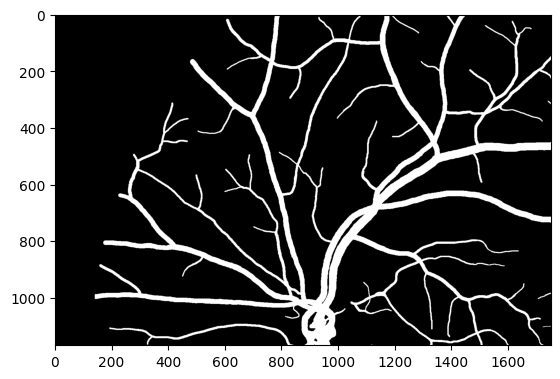

TP: 195388
FP: 721761
FN: 40261
TN: 1088926


In [12]:

test_img = cv2.imread('input-data/04_h.jpg')
test_img = test_img[:test_img.shape[0]//2, :test_img.shape[1]//2]
test_hu = divide_image(test_img)
test_preds_2 = knn_model.predict(test_hu)

fin_mask = cv2.imread('input-data/04_h.tif', 0)
fin_mask[fin_mask > 0] = 1
fin_mask = fin_mask[:test_img.shape[0], :test_img.shape[1]]
fin_mask = fin_mask > 0

plt.imshow(np.reshape(test_preds_2, fin_mask.shape), cmap='gray')
plt.show()

plt.imshow(fin_mask, cmap='gray')
plt.show()

mask_t = np.reshape(test_preds_2, fin_mask.shape)
tp = np.sum(fin_mask[np.where(mask_t == 1)] == 1)
fp = np.sum(fin_mask[np.where(mask_t == 1)] == 0)
fn = np.sum(fin_mask[np.where(mask_t == 0)] == 1)
tn = np.sum(fin_mask[np.where(mask_t == 0)] == 0)

print('TP:', tp)
print('FP:', fp)
print('FN:', fn)
print('TN:', tn)



In [ ]:
mask_t = np.reshape(test_preds_2, fin_mask.shape)
y_pred = mask_t.flatten()
y_true = fin_mask.flatten()

tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
fn = np.sum((y_true == 1) & (y_pred == 0))
tn = np.sum((y_true == 0) & (y_pred == 0))

accuracy = accuracy_score(y_true, y_pred)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
arithmetic_mean = (sensitivity + specificity) / 2
geometric_mean = sqrt(sensitivity * specificity) if sensitivity * specificity > 0 else 0
cm = confusion_matrix(y_true, y_pred)

print("Macierz pomyłek (confusion matrix):")
print(cm)
print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
print(f"Trafność (accuracy): {accuracy:.4f}")
print(f"Czułość (sensitivity): {sensitivity:.4f}")
print(f"Swoistość (specificity): {specificity:.4f}")
print(f"Średnia arytmetyczna (sensitivity & specificity): {arithmetic_mean:.4f}")
print(f"Średnia geometryczna (sensitivity & specificity): {geometric_mean:.4f}")

Macierz pomyłek (confusion matrix):
[[1088926  721761]
 [  40261  195388]]
TP: 195388, FP: 721761, FN: 40261, TN: 1088926
Trafność (accuracy): 0.6276
Czułość (sensitivity): 0.8291
Swoistość (specificity): 0.6014
Średnia arytmetyczna (sensitivity & specificity): 0.7153
Średnia geometryczna (sensitivity & specificity): 0.7061
